In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# jax
import jax.numpy as jnp
import time

import sys
import os

path_ = os.path.abspath(os.path.join('..', '00_utils'))
if path_ not in sys.path:
    sys.path.append(path_)

path_ = os.path.abspath(os.path.join('..', '00_models'))
if path_ not in sys.path:
    sys.path.append(path_)
    
path_ = os.path.abspath(os.path.join('..', '00_utils_training'))
if path_ not in sys.path:
    sys.path.append(path_)

In [2]:
import importlib

def reload_module(module_name, class_name):
    module = importlib.import_module(module_name)
    importlib.reload(module)
    return getattr(module, class_name)

In [3]:
from datetime import datetime, timedelta

start_date = '2015-01-10'
def generate_dates(start_date, sequence_len = 5, frequency = 2):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    date_sequences = [start_date + timedelta(days=i*frequency) for i in range(sequence_len)]
    date_sequences_str = [date.strftime('%Y-%m-%d') for date in date_sequences]
    return date_sequences_str

---
# Single Model

In [393]:
ExperimentRunner = reload_module('optimize_pyomo_rl', 'ExperimentRunner')

tol = 1e-4
start_date = '2015-01-15'
extra_input = {}
extra_input['params_data'] = {'file_path': '../00_data/df_train.csv', 'start_date': start_date, 
                'n_points': 600, 'split': 360, 'n_days': 1, 'm': 0, 
                'prev_hour': True, 'prev_week': True, 'prev_year': True,
                'spacing': 'gauss_radau',
                'encoding': {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'},}

extra_input['params_sequence'] = {'sequence_len': 5, 'frequency': 5}
extra_input['params_model'] = {'layer_sizes': [7, 32, 1], 'penalty': 1e-5}
extra_input['params_solver'] = { "tol" : tol, 
                         "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, 
                         "halt_on_ampl_error" : 'yes', "print_level": 1, "max_iter": 500, 'warm_start_init_point': 'yes'}

extra_input['plot_odeint'] = True
#extra_input['convergence_step'] = 5
extra_input['param_combinations'] = [1e-5]

runner = ExperimentRunner(start_date, 'default', extra_input)
runner.run()

Generating default parameters for ode solver
Running iteration 1 with parameters: 1e-05
{'layer_sizes': [7, 32, 1], 'penalty': 1e-05, 'w_init_method': 'xavier'}
Spacing type: gauss_radau
w init method: xavier
current_16_08
y
Ipopt 3.14.16: tol=0.0001
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
halt_on_ampl_error=yes
print_level=1
max_iter=500
warm_start_init_point=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Ipopt 3.14.16: print_level=1


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 I

In [394]:
single_model_results = runner.results_full
df_single = pd.DataFrame(single_model_results).T
df_single.reset_index(inplace=True)
df_single.rename(columns={'level_0': 'regularization'}, inplace=True)
df_single.drop(columns=['level_1', 'result', 'mse_odeint', 'mse_odeint_test'], inplace=True)
# df_single = df_single[df_single['regularization'] == 1.000000e-06]
df_single

,regularization,times_elapsed,mse_coll_ode,mse_coll_ode_test
0,0.00001,16.774872,0.098708,0.0512
1,0.00001,30.764331,0.045728,0.004215
2,0.00001,19.288233,0.011164,0.278672
3,0.00001,22.822916,0.055801,0.119955
4,0.00001,23.711927,0.22383,0.06687


---
# ADMM

In [418]:
# Constants and Configurations
PENALTY = 1e-3
LAYER_SIZES = [7, 32, 1]
tol = 1e-4
params = {
    "tol": tol,
    "dual_inf_tol": tol,
    "compl_inf_tol": tol,
    "constr_viol_tol": tol,
    "halt_on_ampl_error": 'yes',
    "print_level": 5,
    "max_iter": 500
}
file_path = '../00_data/df_train.csv'
encoding = {'settlement_date': 't', 'temperature': 'var1', 'hour': 'var2', 'nd': 'y'}

date_sequences_str = generate_dates(start_date, sequence_len = 1, frequency = 5)

def prepare_data(start_date, file_path, encoding):
    data_preprocessor = reload_module('preprocess', 'DataPreprocessor')(
        file_path, start_date=start_date, number_of_points = 360, n_days = 1, m = 1, 
        prev_hour = False, prev_week = True, prev_year = True,
        feature_encoding=encoding, split=180, spacing = 'gauss_radau', smooth = False)
    data_subsample = data_preprocessor.load_data()
    return data_preprocessor.preprocess_data(data_subsample), str(data_preprocessor.end_date), data_preprocessor.derivative_matrix()

In [419]:
DataPreprocessor = reload_module('preprocess', 'DataPreprocessor')
NeuralODEPyomoADMM = reload_module('nn_pyomo_admm', 'NeuralODEPyomoADMM')

results = {}
for start_date in date_sequences_str:
    (df_train_1, df_test_1), end_date, (D_1, _) = prepare_data(start_date, file_path, encoding)
    (df_train_2, df_test_2), _, (D_2, D_2_test) = prepare_data(end_date, file_path, encoding)

    # dhift time
    shift = df_train_2['t'].max() - df_train_2['t'].min()
    df_train_2['t'] += shift
    df_test_2['t'] += shift

    # concatenate data
    ys = np.concatenate([df_train_1['y'].values[:, None], df_train_2['y'].values[:, None]], axis = 0)
    ts = np.concatenate([df_train_1['t'], df_train_2['t']])
    Xs = np.concatenate([df_train_1.drop(columns=['y', 't']).values, df_train_2.drop(columns=['y', 't']).values], axis=0)
    Ds = [D_1, D_2]

    # Model and solve
    ode_model = NeuralODEPyomoADMM(
        y_observed=ys, t=ts, first_derivative_matrix=Ds,
        extra_input=Xs, y_init=ys, layer_sizes=LAYER_SIZES,
        act_func="tanh", penalty_lambda_reg=PENALTY, rho=50.0,
        time_invariant=True, w_init_method='xavier', params=params,
        test_data = {'t': df_test_2['t'], 'y': df_test_2['y'], 'D': D_2_test, 'X': df_test_2.drop(columns=['y', 't']).values}
    )
    
    result = ode_model.admm_solve(iterations = 10, tol_primal=1e-3, record=True)
    results[start_date] = result

# prepare test data
t_test = df_test_2['t']
y_test = df_test_2['y']
X_test = df_test_2.drop(columns=['y', 't']).values

----------------------------------------------------------------------------------------------------
ADMM Iteration 1/10; 0
----------------------------------------------------------------------------------------------------
Ipopt 3.14.16: tol=0.0001
dual_inf_tol=0.0001
compl_inf_tol=0.0001
constr_viol_tol=0.0001
halt_on_ampl_error=yes
print_level=5
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    83951
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.......

In [411]:
results

{'2015-02-04': {'primal_residual': [220.51828852710332,
   220.51827974942705,
   2.6285593614909617,
   1.6584991139241425,
   1.0141589113042029,
   0.7857740648566279,
   0.7044033434332543,
   0.6825783200786713,
   0.6762592459325124,
   0.6739420085538297,
   0.6585675381481162,
   0.637992597700746,
   0.6217734940292711,
   0.6101851396473006,
   0.6015657079940311,
   0.5946885057630407,
   0.5888929195402306,
   0.5836945626892286,
   0.5788147226337634,
   0.5741440626485017],
  'mae_collocation': [],
  'mse_collocation': [1.6098075557810325,
   1.6098076527433336,
   1.0822132702996463,
   0.8650988474078615,
   0.7167540619009758,
   0.5459965727208365,
   0.49000434331575776,
   0.4354926890593774,
   0.4021978480373693,
   0.3754218799187545,
   0.36298945394325083,
   0.34425698724903764,
   0.31657376537641163,
   0.3049324600290688,
   0.2953880847328492,
   0.2873057738020472,
   0.2802565147832316,
   0.2739490519008204,
   0.2681865142926538,
   0.26283646070466843

In [412]:
df = pd.DataFrame(results).T
df

,primal_residual,mae_collocation,mse_collocation,mae_diffrax,mse_diffrax,iter,time_elapsed,mse_collocation_test
2015-02-04,"[220.51828852710332, 220.51827974942705, 2.628...",[],"[1.6098075557810325, 1.6098076527433336, 1.082...",[],"[1.6239388841118683, 1.626820649152802, 1.5058...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[21.32583475112915, 23.744200706481934, 30.688...","[1.5116065253509996, 1.5116056637731852, 1.997..."


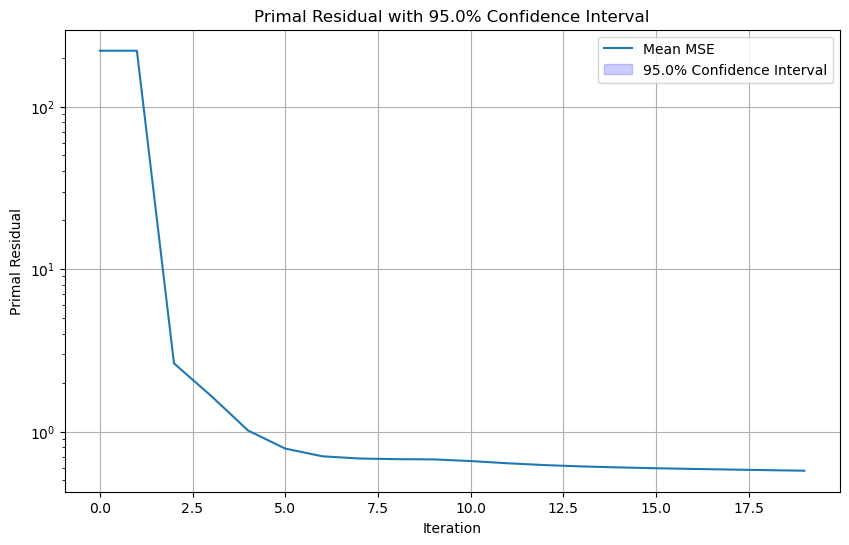

In [413]:
from scipy.stats import t

# Collect all data into a list of dictionaries
data_list = []
for i in range(df.shape[0]):
    mse = df['primal_residual'].iloc[i]
    iters = df['iter'].iloc[i]
    run_label = f'start date = {df.index[i]}'
    data_list.extend([{'iter': it, 'primal_residual': mse_val, 'run': run_label} for it, mse_val in zip(iters, mse)])
    
# Create a new DataFrame from the list
data_df = pd.DataFrame(data_list)

# Group by 'iter' to compute mean and standard deviation
grouped = data_df.groupby('iter')
mean_mse = grouped['primal_residual'].mean()
std_mse = grouped['primal_residual'].std()
n = grouped['primal_residual'].count()

# Compute standard error and confidence intervals
confidence = 0.95
dfree = n - 1
alpha = 1 - confidence
t_crit = t.ppf(1 - alpha/2, dfree)
se_mse = std_mse / np.sqrt(n)
margin_of_error = t_crit * se_mse
upper_bound = mean_mse + margin_of_error
lower_bound = mean_mse - margin_of_error

time_per_iter = np.mean(df.time_elapsed.map(lambda x: x[-1]))/len(mean_mse.index)
times = mean_mse.index* time_per_iter

# Plot the mean with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(mean_mse.index, mean_mse.values, label='Mean MSE')
plt.fill_between(mean_mse.index, lower_bound, upper_bound, color='blue', alpha=0.2, label=f'{confidence*100}% Confidence Interval')

plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Primal Residual')
plt.title(f'Primal Residual with {confidence*100}% Confidence Interval')
plt.legend()
plt.grid()
plt.show()


In [414]:
single_model_results = runner.results_full
df_single = pd.DataFrame(single_model_results).T
df_single.reset_index(inplace=True)
df_single.rename(columns={'level_0': 'regularization'}, inplace=True)
df_single.drop(columns=['level_1', 'result', 'mse_odeint', 'mse_odeint_test'], inplace=True)
df_single

,regularization,times_elapsed,mse_coll_ode,mse_coll_ode_test
0,0.00001,16.774872,0.098708,0.0512
1,0.00001,30.764331,0.045728,0.004215
2,0.00001,19.288233,0.011164,0.278672
3,0.00001,22.822916,0.055801,0.119955
4,0.00001,23.711927,0.22383,0.06687


In [415]:
from scipy.stats import t

# Collect all data into a list of dictionaries
data_list = []
for i in range(df.shape[0]):
    mse = df['mse_collocation'].iloc[i]
    iters = df['iter'].iloc[i]
    run_label = f'start date = {df.index[i]}'
    data_list.extend([{'iter': it, 'mse_collocation': mse_val, 'run': run_label} for it, mse_val in zip(iters, mse)])
    
# Create a new DataFrame from the list
data_df = pd.DataFrame(data_list)

# Group by 'iter' to compute mean and standard deviation
grouped = data_df.groupby('iter')
mean_mse = grouped['mse_collocation'].mean()
std_mse = grouped['mse_collocation'].std()
n = grouped['mse_collocation'].count()

# Compute standard error and confidence intervals
confidence = 0.60
dfree = n - 1
alpha = 1 - confidence
t_crit = t.ppf(1 - alpha/2, dfree)
se_mse = std_mse / np.sqrt(n)
margin_of_error = t_crit * se_mse
upper_bound = mean_mse + margin_of_error
lower_bound = mean_mse - margin_of_error

first_iter_finishes = np.mean(df.time_elapsed.map(lambda x: x[0]))
time_per_iter = np.mean(df.time_elapsed.map(lambda x: x[-1]) - first_iter_finishes)/len(mean_mse.index - 1)
times = mean_mse.index* time_per_iter + first_iter_finishes

In [416]:
df_single

,regularization,times_elapsed,mse_coll_ode,mse_coll_ode_test
0,0.00001,16.774872,0.098708,0.0512
1,0.00001,30.764331,0.045728,0.004215
2,0.00001,19.288233,0.011164,0.278672
3,0.00001,22.822916,0.055801,0.119955
4,0.00001,23.711927,0.22383,0.06687


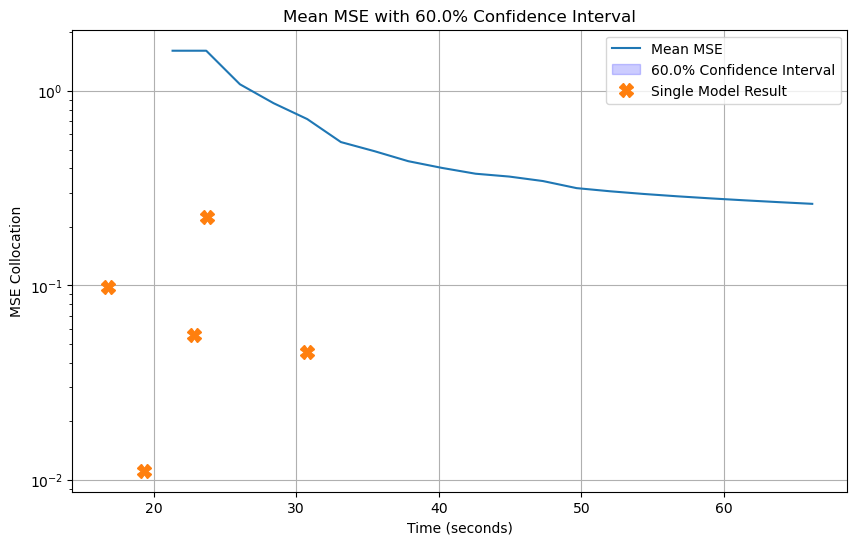

In [417]:
# Plot the mean with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(times, mean_mse.values, label='Mean MSE')
plt.fill_between(times, lower_bound, upper_bound, color='blue', alpha=0.2, label=f'{confidence*100}% Confidence Interval')

#for i in range(df_single.shape[0]):
plt.plot( df_single.times_elapsed.tolist(), df_single.mse_coll_ode.tolist(), 'X', markersize=10, label=f'Single Model Result')
plt.yscale('log')
plt.xlabel('Time (seconds)')
plt.ylabel('MSE Collocation')
plt.title(f'Mean MSE with {confidence*100}% Confidence Interval')
plt.legend()
plt.grid()
plt.show()

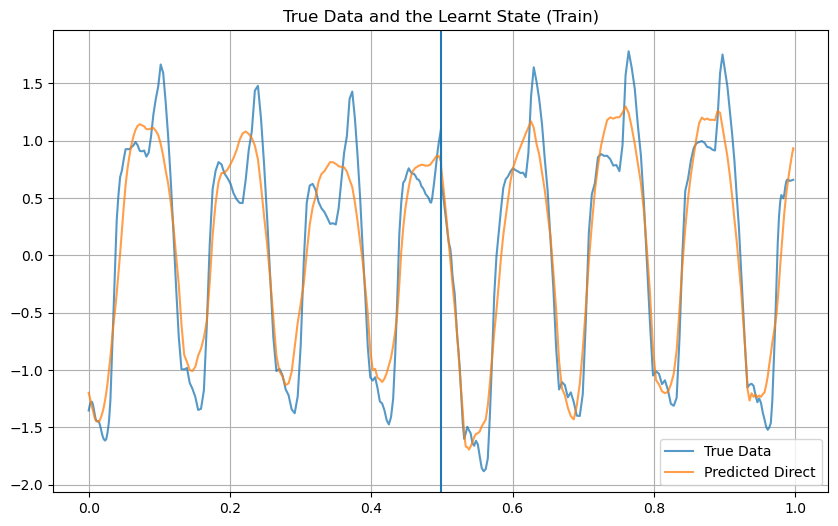

In [338]:
u_model = ode_model.extract_solution().T
plt.figure(figsize=(10, 6))
plt.plot(ts, ys, label='True Data', alpha = 0.75)
plt.plot(ts, u_model, label='Predicted Direct', alpha = 0.75)
plt.axvline(x = np.max(df_train_1['t']))
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("True Data and the Learnt State (Train)")
plt.show()